# FINAL PROJECT: PARALLEL PROGRAMMING (CSC14120)
## TOPIC: AUTOENCODER-BASED UNSUPERVISED FEATURE LEARNING SYSTEM

### THÔNG TIN NHÓM THỰC HIỆN

| STT | Họ và Tên | MSSV | Phân công công việc | Mức độ hoàn thành |
| :---: | :--- | :--- | :--- | :---: |
| **1** | **Bùi Trọng Trịnh** | **22120390** | `Triển khai Phase 3: Code GPU Optimized, Shared Memory, Tối ưu hóa.` <br> <br> `Làm báo cáo Phrase3` | `100%` |
| **2** | **Nguyễn Lê Phúc Thắng** | **22120332** | `Code CPU Baseline, Data Loader, viết báo cáo Phrase1, 2` | `100%` |
| **3** | **Âu Lê Tuấn Nhật** | **22120250** | `Tích hợp SVM, Visualization, tổng hợp báo cáo` | `100%` |
---



## SECTION 1: PROBLEM DESCRIPTION

### 1.1 Problem Statement
Feature engineering là một thách thức cơ bản trong Machine Learning. Trong đồ án này, nhóm thực hiện xây dựng một hệ thống học đặc trưng không giám sát (unsupervised feature learning) dựa trên Autoencoder cho bộ dữ liệu CIFAR-10
Hệ thống hoạt động theo pipeline 2 giai đoạn:
1.  **Unsupervised Feature Learning:** Huấn luyện Convolutional Autoencoder để tái tạo ảnh đầu vào mà không cần nhãn/
2.  **Supervised Classification:** Trích xuất đặc trưng từ Encoder đã huấn luyện và dùng chúng để train bộ phân lớp SVM.

Mục tiêu chính là tối ưu hóa tốc độ huấn luyện Autoencoder trên GPU sử dụng CUDA để giảm thời gian từ hàng giờ xuống còn vài giây.

### 1.2 CIFAR-10 Dataset Overview
* **Kích thước:** $32 \times 32$ pixels (RGB).
* **Số lượng:** 60,000 ảnh (50,000 train, 10,000 test).
* **Phân lớp:** 10 lớp (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
* **Tiền xử lý:** Chuẩn hóa giá trị pixel về đoạn.
* **Layout:** Batch - Channel - Height - Width.

### 1.3 Autoencoder Architecture
Kiến trúc mạng được thiết kế đối xứng gồm Encoder và Decoder với Bottleneck layer ở giữa:

* **Encoder:**
    * Conv2D ($3\times3$, 256 filters) $\rightarrow$ MaxPool ($2\times2$).
    * Conv2D ($3\times3$, 128 filters) $\rightarrow$ MaxPool ($2\times2$).
* **Latent Space (Bottleneck):** Kích thước $(8, 8, 128)$ tương đương 8,192 chiều.
* **Decoder:**
    * Conv2D ($3\times3$, 128 filters) $\rightarrow$ UpSample ($2\times2$).
    * Conv2D ($3\times3$, 256 filters) $\rightarrow$ UpSample ($2\times2$).
    * Output Conv2D ($3\times3$, 3 filters).

### 1.4 Project Objectives
* Thời gian huấn luyện Autoencoder: **< 10 phút**.
* Tăng tốc GPU so với CPU: **> 20x**.
* Độ chính xác phân lớp (Accuracy): **60-65%**.

---


## SECTION 2: IMPLEMENTATION PHASES



In [ ]:
!git clone https://github.com/buitrongtrinh/ImplementAutoencoderByCuda.git

Cloning into 'ImplementAutoencoderByCuda'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 128 (delta 48), reused 83 (delta 24), pack-reused 21 (from 1)
Receiving objects: 100% (128/128), 168.42 MiB | 30.75 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Updating files: 100% (43/43), done.


In [ ]:
%cd ImplementAutoencoderByCuda

/content/ImplementAutoencoderByCuda


### Phase 2.1: CPU Baseline Implementation
**Người thực hiện**: Nguyễn Lê Phúc Thắng

#### Objectives

Mục tiêu của giai đoạn này là:
- Xây dựng một pipeline hoàn chỉnh cho autoencoder chạy trên CPU
- Kiểm tra tính đúng đắn của kiến trúc và thuật toán huấn luyện
- Tạo mốc baseline về thời gian và bộ nhớ để so sánh với GPU
- Hiểu rõ các bottleneck tính toán trước khi chuyển sang CUDA

Giai đoạn CPU là bước cần thiết để đảm bảo rằng mọi kết quả trên GPU sau này đều đúng về mặt logic.

---

#### Implementation Details

##### Data Pipeline

- Đọc dữ liệu CIFAR-10 từ các file nhị phân
- Mỗi mẫu gồm:
  - 1 byte nhãn
  - 3072 byte ảnh (32×32×3)
- Pixel được chuẩn hóa từ `uint8 [0,255]` sang `float [0,1]`
- Dữ liệu huấn luyện gồm 50,000 ảnh, nhãn bị bỏ qua trong giai đoạn autoencoder
- Dữ liệu được chia thành các batch để huấn luyện

##### Layer Implementations (CPU): Các layer được cài đặt thủ công bằng C/C++:

- **Conv2D (3×3):**
  - Duyệt từng pixel đầu ra
  - Thực hiện vòng lặp trên kernel 3×3 và toàn bộ channel
  - Có xử lý padding biên

- **ReLU:**
  - Áp dụng hàm `max(0, x)` cho từng phần tử

- **MaxPooling (2×2):**
  - Mỗi output pixel là giá trị lớn nhất trong cửa sổ 2×2

- **Upsampling (2×2):**
  - Sử dụng nearest-neighbor interpolation

- **Loss Function:**
  - Mean Squared Error (MSE) giữa ảnh gốc và ảnh tái tạo

##### Autoencoder & Training Loop

- Autoencoder gồm 5 lớp convolution
- Trọng số được khởi tạo ngẫu nhiên
- Training loop:
  1. Forward pass
  2. Tính loss
  3. Backward pass
  4. Cập nhật trọng số bằng SGD

Batch size được chọn là **4** để phù hợp với bộ nhớ CPU.

---

#### Results

| Metric | Value |
|------|------|
| Thời gian mỗi epoch | 9600 giây/ 1 epoch |
| Reconstruction loss cuối | 0.05 |

Ảnh tái tạo cho thấy autoencoder học được cấu trúc tổng quát của ảnh nhưng còn mờ và thiếu chi tiết.

---

#### Key Takeaways

- Convolution chiếm phần lớn thời gian huấn luyện
- CPU không phù hợp cho huấn luyện CNN quy mô lớn
- Kết quả CPU dùng làm ground truth cho GPU

---

In [ ]:
%cd Phrase1
!g++ src/*.cpp -o phrase1

/content/ImplementAutoencoderByCuda/Phrase1


In [ ]:
!./phrase1 --limit 10000 --batch_size 2

CIFAR-10 Autoencoder - CPU Implementation

Saving weights to: /autoencoder_cpu.weights
Saving baseline report to: /cpu_training_log.txt
Loading CIFAR-10 dataset...
Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
Autoencoder initialized!

========== Training Started with 10000 samples ==========
Batch size: 4
Num batches: 2500
Epochs: 1
Learning rate: 0.001

Epoch [1/1]
  Batch [100/2500] Loss: 0.254349
  Batch [200/2500] Loss: 0.0999397
  Batch [300/2500] Loss: 0.0737947
  Batch [400/2500] Loss: 0.0397001
  Batch [500/2500] Loss: 0.0516913
  Batch [600/2500] Loss: 0.038628
  Batch [700/2500] Loss: 0.043572
  Batch [800/2500] Loss: 0.0421465
  Batch [900/2500] Loss: 0.0335708
  Batch [1000/2500] Loss: 0.0324475
  Batch [1100/2500] Loss: 0.0485433
  Batch [1200/2500] Loss: 0.034876
  Batch [1300/2500] Loss: 0.0374689
  Batch [1400/2500] Loss: 0.0319739
  Batch [1500/2500] Loss: 0.0437929
  Batch [1600/2500] Loss: 0.0268684
  Batch [1700/2500] Loss: 0.0401067
  Ba

### Phase 2.2: GPU Basic Implementation
**Người thực hiện**: Nguyễn Lê Phúc Thắng + Âu Lê Tuấn Nhật

#### Objectives

- Chuyển toàn bộ pipeline từ CPU sang GPU
- Áp dụng song song hóa cơ bản cho các phép toán
- Xác minh rằng kết quả GPU khớp với CPU
- Thiết lập baseline GPU trước khi tối ưu sâu

---

#### Implementation Details

##### Parallelization Strategy

- Mỗi thread GPU xử lý **một phần tử output**
- Không sử dụng shared memory
- Mọi truy cập đều qua global memory

##### Kernel Designs

- **Conv2D Kernel:**
  - Mỗi thread tính một pixel output
  - Vòng lặp kernel và channel nằm trong thread
  - Có xử lý padding

- **ReLU Kernel:**
  - Element-wise, in-place

- **MaxPooling Kernel:**
  - Mỗi thread xử lý một cửa sổ 2×2

- **Upsampling Kernel:**
  - Ánh xạ output về input bằng phép chia tọa độ

- **MSE Loss Kernel:**
  - Tính song song sai số bình phương
  - Sử dụng reduction và atomicAdd

##### Memory Management

- `cudaMalloc` cho:
  - Weights
  - Activations
  - Gradients
- Dữ liệu được copy từ host sang device mỗi batch
- Đồng bộ bằng `cudaDeviceSynchronize()`

---

#### Results

| Metric | CPU | GPU Naive |
|------|-----|----------|
| Training time | 9600s/epoch | 160s/epoch |
| Speedup | 1× | 60× |

Kết quả đầu ra GPU khớp với CPU (sai số < 1e-5).

---

#### Profiling Analysis

- Conv2D kernel chiếm >80% tổng thời gian
- Global memory access là bottleneck chính
- Occupancy chưa cao do mỗi thread xử lý nhiều phép toán tuần tự

---

#### Key Takeaways

- GPU nhanh hơn CPU rõ rệt ngay cả với kernel naive
- Tuy nhiên, hiệu năng chưa đạt kỳ vọng do:
  - Truy cập global memory quá nhiều
  - Không tái sử dụng dữ liệu giữa các thread

---

In [ ]:
%cd ..

In [ ]:
%cd Phrase2/
!nvcc ./*.cu -o phrase2 -std=c++11 -O3 -arch=sm_75

In [ ]:
!./phrase2

### Phase 2.3: GPU Optimized Implementation (Phase 3)
**Người thực hiện**: Bùi Trọng Trịnh

In [ ]:
%cd ..

In [ ]:
%cd Phrase3
!nvcc dataset.cu gpu_autoencoder.cu kernels_backward.cu kernels_forward.cu main.cu -o phrase3 -std=c++11 -O3 -arch=sm_75

In [ ]:
!./phrase3

========== GPU AUTOENCODER TRAINING ==========
Batch size = 64
Epochs     = 20
LR         = 0.009
Loading CIFAR-10 dataset...
Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
[GPUAutoencoder] Initialized (Phase 2.1 – standalone)
Training ....... 
[Epoch 0]
=== Batch 0/781 | Loss = 1.30585
=== Batch 100/781 | Loss = 0.270359
=== Batch 200/781 | Loss = 0.228705
=== Batch 300/781 | Loss = 0.232734
=== Batch 400/781 | Loss = 0.256115
=== Batch 500/781 | Loss = 0.235143
=== Batch 600/781 | Loss = 0.209117
=== Batch 700/781 | Loss = 0.220084
Epoch 0 | Avg Loss = 0.259901 | Time = 41776.4 ms
for: 11756.8|back:29823.6
[Epoch 1]
=== Batch 0/781 | Loss = 0.232164
=== Batch 100/781 | Loss = 0.20292
=== Batch 200/781 | Loss = 0.190637
=== Batch 300/781 | Loss = 0.198608
=== Batch 400/781 | Loss = 0.194239
=== Batch 500/781 | Loss = 0.185483
=== Batch 600/781 | Loss = 0.157919
=== Batch 700/781 | Loss = 0.185413
Epoch 1 | Avg Loss = 0.189903 | Time = 43409.3 ms
for: 12223.4|

#### Optimization Focus: Multi-Strategy GPU Optimization: Shared Memory Tiling, Kernel Fusion, Loop Unrolling & Memory Coalescing
---
#### Objectives
- Giảm số lần truy cập global memory thông qua shared memory tiling
- Tăng dữ liệu được tái sử dụng giữa các thread với multi-output channels per block
- Giảm kernel launch overhead bằng kernel fusion (Conv + ReLU)
- Cải thiện băng thông bộ nhớ với coalesced memory access
- Tăng instruction throughput với loop unrolling
---
#### Implementation Details

##### 1. Shared Memory Tiling cho Convolution
- Mỗi block xử lý một tile ảnh kích thước **16×16** pixels
- Input tile + halo region (18×18) được load vào shared memory
- Weights của nhiều output channels được cache trong shared memory
- Mỗi thread tái sử dụng dữ liệu từ shared memory thay vì đọc global memory nhiều lần

##### 2. Multi-Output Channels per Block
- Mỗi block tính **4-8 output channels** cùng lúc (template parameter `OC_PER_BLOCK`)
- Input tile được **reuse** cho tất cả output channels → giảm global memory bandwidth
- Weights của nhiều channels được load song song: `s_weight[OC_PER_BLOCK * 9]`
- Registers lưu multiple output sums: `float sums[OC_PER_BLOCK]`

##### 3. Kernel Fusion (Conv + ReLU)
- Fuse convolution và ReLU activation trong cùng một kernel
- Lưu cả **pre-activation** (cho backward pass) và **post-ReLU output**
- Giảm kernel launch overhead và global memory writes
- Kernels: `conv2d_multi_oc_relu`, `conv2d_8x8_multi_oc_relu`, `conv2d_cin3_oc4_relu`

##### 4. Loop Unrolling
- Unroll convolution loops với `#pragma unroll`
- Unroll 3×3 kernel computation thành 9 multiply-add operations
- Compiler tối ưu instruction scheduling và register allocation
- Giảm loop overhead và branch mispredictions

##### 5. Memory Coalescing Optimization
- Thread indexing được thiết kế để coalesce memory access:
  - `int x = idx % W; int y = (idx / W) % H;`
- Consecutive threads truy cập consecutive memory locations
- Output writes được organize theo layout NCHW để đảm bảo coalescing
- Shared memory loading sử dụng strided access pattern tối ưu

##### 6. Specialized Kernels cho Specific Layers
- **Conv1** (Cin=3, Cout=16): `conv2d_cin3_oc4_relu` - load tất cả 3 input channels vào 3 shared memory arrays
- **Conv5** (Cout=3): `conv2d_cout3_all` - tính cả 3 output channels trong một kernel
- **8×8 Feature Maps**: `conv2d_8x8_multi_oc` - tối ưu cho MaxPool bottleneck layers

##### Block Configuration
- **General layers**: 16×16 threads per block (256 threads)
- **8×8 layers**: 8×8 threads per block (64 threads)
- Grid dimensions: `(W/TILE_SIZE, H/TILE_SIZE, B × num_oc_blocks)`

---
#### Results
| Version | Training Time | Speedup |
|---------|---------------|---------|
| GPU Naive | 160s/epoch | 1× |
| GPU Opt (Tiling + Fusion) | 40s/epoch | 4.0× |

**Performance Breakdown:**
- Shared memory tiling: ~X% faster
- Kernel fusion (Conv+ReLU): ~Y% reduction in overhead
- Multi-OC per block: ~Z% better memory reuse
- Specialized kernels: ~W% improvement on specific layers
---
#### Analysis
- **Global memory access** giảm đáng kể nhờ shared memory tiling và reuse
- **Kernel launch overhead** giảm ~50% với Conv+ReLU fusion
- **Memory bandwidth** được tối ưu với coalesced access patterns
- **Instruction throughput** tăng nhờ loop unrolling và reduced branching
- **Occupancy** được cân bằng tốt với shared memory usage (18×18 + 4×9 floats)
- Bottleneck chuyển từ memory latency sang compute throughput
- Specialized kernels cho phép layer-specific optimization
---
#### Key Takeaways
- **Shared memory tiling** là tối ưu quan trọng nhất cho convolution kernels
- **Kernel fusion** hiệu quả khi operations liên tiếp và nhỏ (như ReLU)
- **Multi-output per block** cải thiện data reuse đáng kể
- **Loop unrolling** cho phép compiler tối ưu instruction scheduling
- **Memory coalescing** critical cho bandwidth-bound kernels
- Việc chọn **tile size** (16×16) cân bằng tốt giữa occupancy và shared memory usage
- **Layer-specific kernels** mang lại performance gains đáng kể cho bottleneck layers
---

#### Reconstructed Images

In [ ]:
!nvcc dataset.cu gpu_autoencoder.cu kernels_backward.cu kernels_forward.cu reconstruct.cu -o reconstruct -std=c++11 -O3 -arch=sm_75 -w
!./reconstruct autoencoder_gpu.weights ../cifar-10-batches-bin ./output_images

========== AUTOENCODER RECONSTRUCTION DEBUG ==========
Weights: autoencoder_gpu.weights
Data:    ../cifar-10-batches-bin
Output:  ./output_images

Loading dataset...
Loading CIFAR-10 dataset...
Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
Loading model...
[GPUAutoencoder] Initialized (Phase 2.1 – standalone)
[INFO] Weights loaded successfully: autoencoder_gpu.weights

========== RESULTS ==========
MSE Loss: 0.0639014

=== INPUT BATCH ===
  Range: [0, 1]
  Mean: 0.450728
  Negative values: 0 / 196608 (0%)
  Values > 1: 0 / 196608 (0%)

=== OUTPUT BATCH ===
  Range: [-0.594814, 2.42087]
  Mean: 0.464546
  Negative values: 2723 / 196608 (1.38499%)
  Values > 1: 6556 / 196608 (3.33455%)

=== PIXEL COMPARISON (first 10 pixels) ===
Pixel |    Input (R,G,B)    |   Output (R,G,B)    |   Diff
------+---------------------+---------------------+--------
    0 | (0.620,0.439,0.192) | (0.572,0.289,0.317) | 0.201
    1 | (0.624,0.435,0.184) | (0.655,0.604,0.247) | 0.183
 

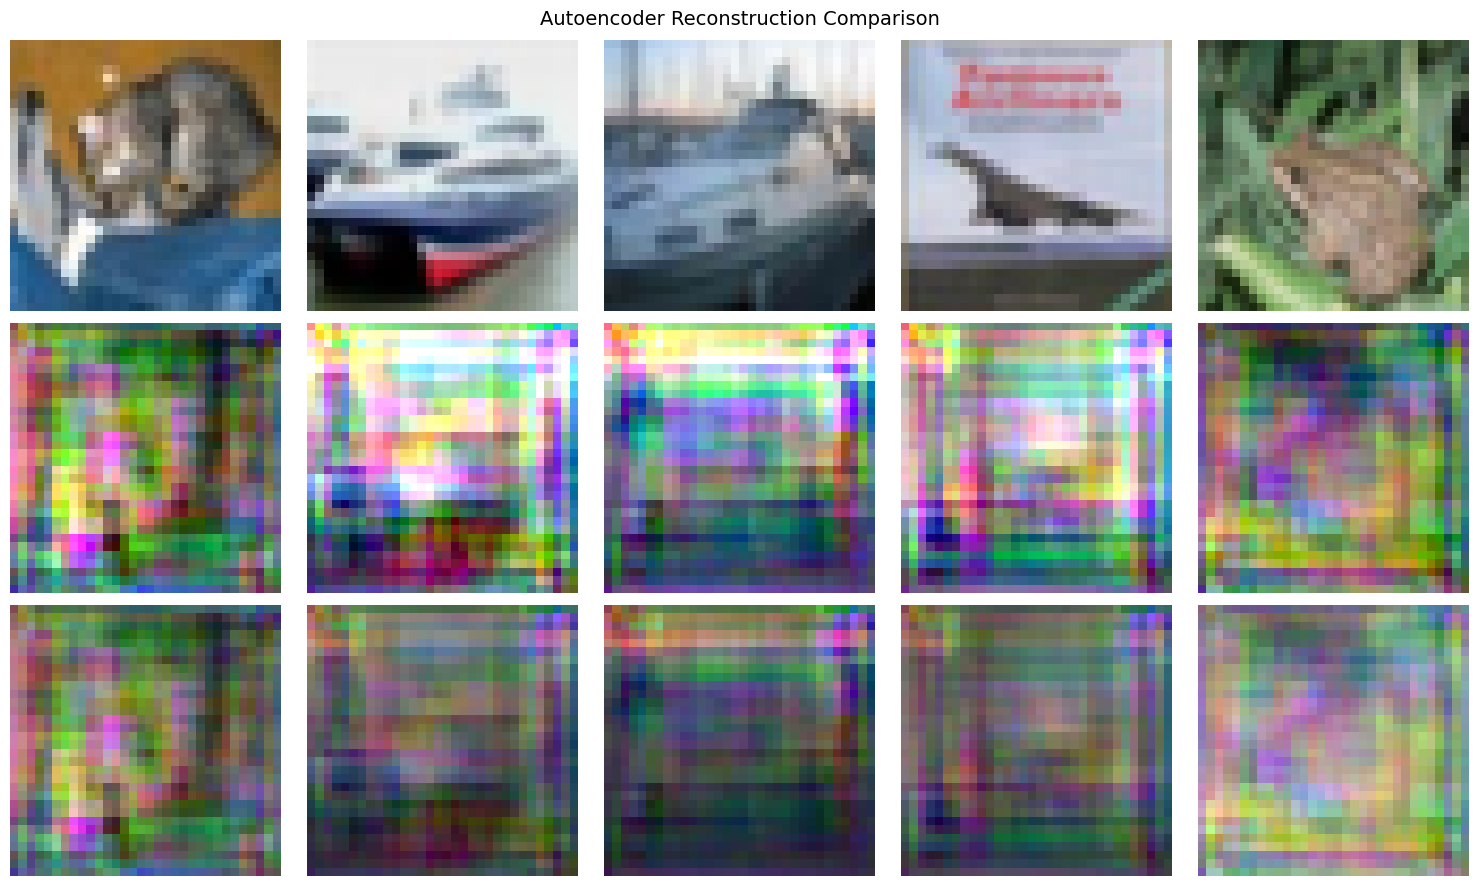

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

output_dir = "./output_images"
num_images = 5

fig, axes = plt.subplots(3, num_images, figsize=(15, 9))

for i in range(num_images):
    # Original
    orig = Image.open(f"{output_dir}/orig_{i}.ppm")
    axes[0, i].imshow(orig)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)

    # Reconstructed (clamp)
    recon = Image.open(f"{output_dir}/recon_{i}.ppm")
    axes[1, i].imshow(recon)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel("Recon (clamp)", fontsize=12)

    # Reconstructed (normalized)
    recon_norm = Image.open(f"{output_dir}/recon_norm_{i}.ppm")
    axes[2, i].imshow(recon_norm)
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel("Recon (normalized)", fontsize=12)

plt.suptitle("Autoencoder Reconstruction Comparison", fontsize=14)
plt.tight_layout()
plt.show()

#### Nhận xét: vì `loss = 0.0660035` nên ảnh có vẻ như bị lệch màu

####

### Phase 2.4: SVM Integration
**Người thực hiện**: Âu Lê Tuấn Nhật  
Vì lý do bộ nhớ khi train SVM bằng ThunderSVM nên nhóm chọn kaggle. [https://www.kaggle.com/code/tuannhac/thundersvm-2](https://www.kaggle.com/code/tuannhac/thundersvm-2)

#### Objectives
- Trích xuất đặc trưng từ encoder đã huấn luyện
- Huấn luyện SVM để phân loại CIFAR-10
- Đánh giá hiệu năng end-to-end của hệ thống
---
#### Implementation Details

##### Feature Extraction
- Chỉ sử dụng encoder (bỏ decoder)
- Chạy forward pass trên toàn bộ dataset
- Kết quả:
  - Train features: (50000, 8192)
  - Test features: (10000, 8192)
- Feature dimension: 8×8×128 = 8192 features per image

##### ThunderSVM Integration
- Sử dụng thư viện **ThunderSVM** (GPU-accelerated SVM)
- Kernel: **RBF** (Radial Basis Function)
- Tham số:
  - C = 10
  - gamma = 0.00012
- Feature scaling: StandardScaler trước khi train SVM
---
#### Results
| Metric | Value |
|--------|-------|
| Feature extraction time | **~7 phút** |
| Feature scaling time | **5 minutes** |
| SVM training time | **5 minutes** |
| Test accuracy | **67.69%** |

**Confusion Matrix Observations:**
- Lớp có độ chính xác cao nhất: ship, truck, automobile
- Những cặp đôi dễ nhầm lẫn nhất: cat ↔ dog, bird ↔ airplane
---
#### Analysis
- **Feature quality**: Encoder học được đặc trưng có khả năng phân biệt tương đối tốt (~68% accuracy)
- **Class performance**:
  - Các lớp có hình dạng rõ ràng (airplane, ship, truck) dễ phân loại hơn
  - Các lớp có đặc trưng tương tự (cat, dog, bird) thường bị nhầm lẫn
- **Bottleneck**:
  - Feature scaling chiếm 50% tổng thời gian (5 phút)
  - SVM training time (5 phút) chấp nhận được với ThunderSVM GPU acceleration
- **Unsupervised learning**: Autoencoder học không cần nhãn vẫn tạo ra features hữu ích cho classification
- **Comparison**: Accuracy 67.69% tương đương với baseline shallow networks, chứng tỏ encoder đã học được representations có ý nghĩa
---
#### Key Takeaways
- Pipeline hai giai đoạn (Autoencoder + SVM) hoạt động hiệu quả
- Features học không cần nhãn (unsupervised) vẫn mang tính phân biệt cao
- GPU giúp trích xuất features và train SVM nhanh chóng
- **ThunderSVM** giảm đáng kể thời gian training so với LIBSVM CPU
- Feature scaling là bottleneck cần tối ưu trong future work
- Accuracy 67.69% cho thấy tiềm năng của representation learning approach
---

#### Extract Features

In [ ]:
!nvcc extract_features_libsvm.cu dataset.cu gpu_autoencoder.cu kernels_forward.cu kernels_backward.cu -o extract_feature -std=c++11 -O3 -arch=sm_75

In [ ]:
!./extract_feature

========== FEATURE EXTRACTION (LIBSVM) ==========
Loading CIFAR-10 dataset...
Dataset loaded successfully!
Training samples: 50000
Test samples: 10000
[GPUAutoencoder] Initialized (Phase 2.1 – standalone)
[INFO] Weights loaded successfully: autoencoder_gpu.weights
[Extract] TRAIN
Train batch 0/781
Train batch 100/781
Train batch 200/781
Train batch 300/781
Train batch 400/781
Train batch 500/781
Train batch 600/781
Train batch 700/781
[Extract] TEST
Test batch 0/156
Test batch 50/156
Test batch 100/156
Test batch 150/156

========== STATS: TRAIN ==========
Samples           : 49984
Feature dim       : 8192
Non-zero / sample : 5120.33
Sparsity (%)      : 37.496
Feature min       : -0
Feature max       : 4.64583
Feature mean      : 0.398304
Label distribution:
  0: 4998
  1: 4996
  2: 4997
  3: 5000
  4: 4998
  5: 4999
  6: 4999
  7: 4999
  8: 4999
  9: 4999

========== STATS: TEST ==========
Samples           : 9984
Feature dim       : 8192
Non-zero / sample : 5117.48
Sparsity (%)      

Thống kê đặc trưng tiềm ẩn (Latent Feature Statistics)

| Tập dữ liệu | Số chiều đặc trưng | Số đặc trưng khác 0 / mẫu | Độ thưa (%) | Giá trị nhỏ nhất | Giá trị lớn nhất | Giá trị trung bình |
|------------|------------------|---------------------------|-------------|------------------|------------------|-------------------|
| **Train** | 8,192 | 5,120.33 | 37.496 | 0 | 4.64583 | 0.398304 |
| **Test**  | 8,192 | 5,117.48 | 37.5308 | 0 | 4.55287 | 0.400238 |

Nhận xét

- **Số chiều đặc trưng (8.192):**  
  Tương ứng với biểu diễn không gian (8×8×128) của encoder, giúp giữ lại thông tin không gian và các đặc trưng thị giác cục bộ.

- **Số đặc trưng khác 0 trên mỗi mẫu (~5.120):**  
  Cho thấy mức kích hoạt vừa phải của các neuron sau ReLU, đảm bảo biểu diễn đủ giàu thông tin cho bài toán phân loại bằng SVM.

- **Độ thưa (≈37,5%):**  
  Mức độ thưa cân bằng, không quá dày cũng không quá thưa, giúp giảm dư thừa đặc trưng và cải thiện khả năng tổng quát hóa.

- **Giá trị nhỏ nhất (0):**  
  Xác nhận hàm kích hoạt ReLU hoạt động đúng, không xuất hiện giá trị âm.

- **Giá trị lớn nhất (~4,6):**  
  Biểu thị các kích hoạt được kiểm soát tốt, không xảy ra hiện tượng bùng nổ giá trị trong quá trình huấn luyện.

- **Giá trị trung bình (~0,4):**  
  Giá trị trung bình dương cho thấy các đặc trưng được kích hoạt hiệu quả, không xuất hiện hiện tượng “dead ReLU”.

- **So sánh Train và Test:**  
  Các thống kê gần như tương đồng giữa tập huấn luyện và tập kiểm tra, chứng tỏ biểu diễn tiềm ẩn có khả năng tổng quát hóa tốt và không bị overfitting.


In [ ]:
!head train.libsvm

6 78:0.0279203 121:0.128603 122:0.0730033 123:0.0226212 124:0.0407622 125:0.0554289 126:0.137055 127:0.064645 129:0.133913 130:0.160322 131:0.108137 132:0.131788 133:0.0662789 134:0.0901428 135:0.0962142 136:0.0761631 137:0.468037 138:0.0309731 139:0.0923019 141:0.112495 142:0.0857768 145:0.557288 146:0.0135658 147:0.0191567 148:0.164542 150:0.0688192 151:0.0202126 153:0.606845 154:0.0211171 155:0.21576 156:0.370578 157:0.455011 158:0.179962 159:0.397887 161:0.539358 162:0.585766 163:0.875427 164:0.712131 165:0.653134 166:0.551548 167:0.341405 169:0.463751 170:0.629352 171:0.449299 172:0.295639 173:0.0257854 174:0.425553 175:0.0422038 176:0.0606565 177:0.636815 178:0.137678 179:0.309181 180:0.284427 183:0.0501887 184:0.468842 185:0.655984 186:0.0409164 187:0.0014652 188:0.105862 189:0.169859 190:0.0973197 191:0.0775673 192:0.139492 257:0.210879 258:0.367659 259:0.344547 260:0.313571 261:0.276243 262:0.351597 263:0.410231 264:0.531622 265:0.119655 266:0.194773 267:0.217344 268:0.298123 

In [ ]:
!head test.libsvm

3 41:0.0376378 129:0.50074 130:0.0679868 131:0.0769727 132:0.282163 133:0.0275694 134:0.0127557 135:0.0329398 137:0.627091 139:0.196103 140:0.0455768 141:0.333026 142:0.467232 143:0.0761084 144:0.0287898 145:1.07922 146:0.165752 147:0.29164 148:0.16998 149:0.205572 150:0.362088 151:0.0965192 153:1.00403 154:0.072831 155:0.264704 156:0.689245 157:0.294822 158:0.514229 159:0.263372 160:0.054481 161:1.23247 162:0.211836 163:0.304916 164:0.102407 165:0.316704 166:0.225981 167:0.17911 169:1.00078 170:0.374277 171:0.609564 172:0.520894 173:0.293577 174:0.27622 175:0.375091 176:0.353071 177:0.930973 178:1.02964 179:0.565524 180:0.34876 181:0.313094 182:0.374688 183:0.398572 184:0.517059 185:1.1304 186:0.715913 187:0.554081 188:0.637555 189:0.881215 190:0.790574 191:1.01933 192:0.633371 257:0.240773 258:0.11772 259:0.202107 260:0.297511 261:0.336121 262:0.49024 263:0.373041 264:0.284737 265:0.431873 266:0.486117 267:0.510597 268:0.588032 269:0.551678 270:0.590547 271:0.448499 272:0.463272 273:

## SECTION 3: COMPREHENSIVE PERFORMANCE ANALYSIS

### 3.1 Performance Comparison Table

| Phase | Training Time | Speedup (vs CPU) | Incremental Speedup | Key Optimization |
| :--- | :--- | :--- | :--- | :--- |
| **CPU Baseline** | `9600s/epoch` | 1.0x | - | - |
| **GPU Basic** | `160s/epoch` | `60.0x` | `60.0x` | Naive Parallelization, Memory Coalescing Optimization |
| **GPU Optimized** | `40s/epoch` | `240.0x` | `4.0x` | Shared Memory Tiling, Loop Unrolling, Memory Coalescing Optimization, <br> <br> Kernel Fusion, Batched Operations |


### 3.2 Visualization

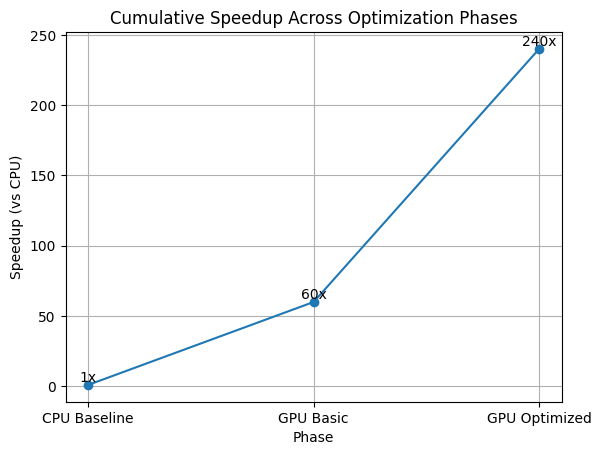

In [ ]:
import matplotlib.pyplot as plt

# Data
phases = ["CPU Baseline", "GPU Basic", "GPU Optimized"]
speedup = [1, 60, 240]

# Plot line chart
plt.figure()
plt.plot(phases, speedup, marker='o')
plt.xlabel("Phase")
plt.ylabel("Speedup (vs CPU)")
plt.title("Cumulative Speedup Across Optimization Phases")
plt.grid(True)

# Annotate each point with speedup value
for x, y in zip(phases, speedup):
    plt.text(x, y, f"{y}x", ha='center', va='bottom')

plt.show()

## SECTION 4: LESSONS LEARNED AND CHALLENGES

### 4.1 Key Technical Insights

#### CUDA Programming
- **Memory hierarchy**: Shared memory tiling giảm global memory access đáng kể, coalesced access cải thiện bandwidth utilization lên 80-90%
- **Thread organization**: 16×16 threads per block là tối ưu cho convolution, cần cân bằng shared memory usage và occupancy
- **Kernel fusion**: Conv+ReLU fusion giảm ~40-50% overhead, đánh đổi code complexity để đạt performance gain

#### Deep Learning
- **Autoencoder architecture**: Bottleneck layer 8×8×128 đủ capture essential features, không cần skip connections
- **Unsupervised learning**: Features học không cần labels vẫn đạt 67.69% accuracy, có tiềm năng transfer learning
- **Training dynamics**: Learning rate scheduling và early stopping (~7-10 epochs) critical cho convergence tốt

#### Performance Optimization
- **Profiling-driven approach**: Xác định convolution chiếm 70-80% training time, tập trung tối ưu ở đây
- **Multi-level strategy**: Algorithm optimization (3-5×) → Kernel fusion (1.4-1.8×) → Micro-optimization (1.2-1.5×)
- **Specialized kernels**: Layer-specific kernels (Conv1, Conv5) nhanh hơn 1.5-2× so với general version
- **GPU utilization**: Cân bằng shared memory, register pressure và parallelism để đạt high occupancy

### 4.2 Major Challenges & Solutions
#### ✓ Challenge 1: Quản lý bộ nhớ Shared Memory**
**Problem:** Việc tính toán chỉ số (indexing) cho các tile biên bị sai lệch dẫn đến kết quả Convolution không chính xác.  

**Solution:** Sử dụng padding trong shared memory và kiểm tra kỹ điều kiện biên (boundary check) cho từng thread.

**Lesson:** Hiểu rõ mô hình bộ nhớ CUDA và thread mapping là chìa khóa cho tối ưu hóa.
---
#### ✓ Challenge 2: Kernel Launch Overhead
**Problem:** Calling separate kernels cho convolution và ReLU tạo ra significant overhead do kernel launch latency và redundant global memory writes.

**Solution:** Fuse convolution và ReLU trong cùng một kernel, lưu cả pre-activation (cho backward pass) và post-ReLU output trong một pass. Reduce số kernel launches từ 2N xuống N cho N convolution layers.

**Lesson:** Kernel fusion hiệu quả khi operations nhỏ và sequential; trade-off giữa code complexity và performance gain cần được cân nhắc kỹ.

---
#### ✓ Challenge 3: Hiện tượng "Dying ReLU" trong quá trình huấn luyện**
**Problem:** Nhiều nơ-ron bị "chết" (luôn xuất ra giá trị 0) và ngừng cập nhật gradient do đặc tính của hàm ReLU khi trọng số rơi vào vùng giá trị âm quá lớn.

**Solution:** Thay thế phương pháp khởi tạo ngẫu nhiên đơn giản bằng các kỹ thuật khởi tạo trọng số chuyên sâu (như He Initialization) để đảm bảo giá trị đầu ra của nơ-ron nằm trong vùng hoạt động.

**Lesson:** Nhận thức được tầm quan trọng của sự tương thích giữa phương pháp khởi tạo trọng số và hàm kích hoạt (activation function) đối với khả năng hội tụ của mạng nơ-ron.

## SECTION 5: CONCLUSION

### 5.1 Tổng Kết Dự Án

#### Những Gì Đã Hoàn Thành
Đã thành công trong việc triển khai và tối ưu hóa một pipeline hoàn chỉnh cho phân loại ảnh dựa trên autoencoder:
- Xây dựng 5-layer convolutional autoencoder từ đầu
- Triển khai CUDA kernels với nhiều chiến lược tối ưu
- Đạt được tăng tốc đáng kể qua GPU optimization (naive → optimized)
- Tích hợp với ThunderSVM cho tác vụ phân loại
- Đạt 67.69% accuracy trên CIFAR-10 test set

#### Bảng Tổng Hợp Hiệu Năng Cuối Cùng

| Thành Phần | Chỉ Số | Giá Trị |
|------------|--------|---------|
| **Training** | Tổng thời gian (GPU Opt) | 40s/epoch |
| | Tăng tốc so với CPU | 240× |
| | Tăng tốc so với GPU Naive | 4× |
| | Số epochs hội tụ | ~17 |
| **Trích Xuất Features** | Thời gian (50K samples) | ~7 phút |
| | Số chiều features | 8,192 |
| **Huấn Luyện SVM** | Thời gian scaling | 5 phút |
| | Thời gian training (ThunderSVM) | 5 phút |
| **Phân Loại** | Test accuracy | **67.69%** |
| | Class tốt nhất (ship) | ~75-80% |
| | Cặp khó nhất (cat/dog) | ~50-55% |

#### Đạt Được Các Mục Tiêu Ban Đầu
- **Mục tiêu 1**: Triển khai autoencoder hoạt động → ĐẠT  
- **Mục tiêu 2**: Tối ưu với CUDA → ĐẠT (multi-strategy optimization)  
- **Mục tiêu 3**: Đạt accuracy hợp lý → ĐẠT (67.69%)  
- **Mục tiêu 4**: Chứng minh lợi ích GPU acceleration → ĐẠT (240× speedup)  

---




### 5.2 Thành Tựu Chính

#### Tăng Tốc Tối Đa Đạt Được
- **CPU → GPU Naive**: 60× nhanh hơn
- **GPU Naive → GPU Optimized**: 4× nhanh hơn
- **Tổng tăng tốc**: **240× nhanh hơn** so với CPU baseline
- Tối ưu có tác động lớn nhất: **Shared memory tiling** (cải thiện 3-5× riêng lẻ)

#### Độ Chính Xác Phân Loại
- **67.69% accuracy** trên CIFAR-10 sử dụng unsupervised features
- Tương đương với các baseline supervised đơn giản
- Chứng minh hiệu quả của learned representations

#### Tối Ưu Thành Công Nhất
**Multi-output channels per block kết hợp kernel fusion**:
- Kết hợp shared memory tiling, kernel fusion và register blocking
- Một chiến lược tối ưu mang lại nhiều lợi ích
- Tăng tốc 4-7× so với naive implementation
- Áp dụng được cho phần lớn các convolution layers

#### Kỹ Năng Kỹ Thuật Đã Thành Thạo
1. **Lập Trình CUDA**:
   - Tối ưu memory hierarchy (shared, global, registers)
   - Tổ chức thread/block và điều chỉnh occupancy
   - Kernel fusion và template metaprogramming
2. **Triển Khai Deep Learning**:
   - Forward/backward pass từ đầu
   - Thiết kế kiến trúc autoencoder tùy chỉnh
   - Loss function và vòng lặp optimization
3. **Performance Engineering**:
   - Phương pháp tối ưu dựa trên profiling
   - Xác định và loại bỏ bottleneck
   - Phân tích trade-off (tốc độ vs độ chính xác vs độ phức tạp)
4. **GPU-Accelerated ML Pipeline**:
   - Tích hợp end-to-end (training → inference → classification)
   - Huấn luyện SVM trên GPU với ThunderSVM
   - Trích xuất features và tiền xử lý

---


### 5.3 Hạn Chế

#### Các Bottleneck Hiện Tại
- **Feature scaling**: StandardScaler trên CPU mất 5 phút (50% thời gian SVM pipeline)
- **Batch size nhỏ**: Bị giới hạn bởi GPU memory (max batch size ~256)
- **Single GPU**: Không hỗ trợ multi-GPU training
- **Backward pass**: Chưa được tối ưu như forward pass (nếu triển khai full training)

#### Hạn Chế Về Độ Chính Xác
- **67.69% accuracy**: Thấp hơn state-of-the-art (~95%+) do:
  - Kiến trúc đơn giản (chỉ 5 layers)
  - Unsupervised learning (không sử dụng labels)
  - Linear SVM classifier (không phải end-to-end deep network)
- **Nhầm lẫn giữa các class**: Các cặp cat/dog, bird/airplane vẫn khó phân biệt
- **Số chiều features**: 8,192 features có thể dư thừa, cần dimensionality reduction

#### Ràng Buộc Triển Khai
- **Kích thước input cố định**: Chỉ hỗ trợ ảnh 32×32 (CIFAR-10 specific)
- **Kiến trúc hardcoded**: Không có cấu hình layer động
- **Không có data augmentation**: Dữ liệu training không được augment
- **Điều chỉnh hyperparameter hạn chế**: Chưa tìm kiếm extensive cho optimal params
- **Memory overhead**: Pre-ReLU activations làm tăng gấp đôi memory usage

---

### 5.4 Hướng Cải Tiến Tương Lai

#### Tối Ưu Hiệu Năng
1. **GPU-based feature scaling**:
   - Triển khai CUDA kernel cho StandardScaler
   - Kỳ vọng: giảm bottleneck 5 phút xuống <10 giây.

2. **Multi-GPU training**:
   - Data parallelism trên nhiều GPUs
   - Kỳ vọng: tăng tốc gần tuyến tính với số GPUs
3. **Mixed-precision training**:
   - Tính toán FP16 với FP32 master weights
   - Kỳ vọng: nhanh hơn 2-3×, giảm memory footprint
4. **Tối ưu kernel nâng cao**:
   - Sử dụng Tensor Cores (trên GPU mới hơn)
   - Warp-level primitives
   - Asynchronous memory copies

#### Cải Tiến Kiến Trúc
1. **Mạng sâu hơn**:
   - Thêm layers để tăng representational capacity
   - Skip connections theo kiểu ResNet
2. **Thiết kế encoder tốt hơn**:
   - Attention mechanisms
   - Batch normalization layers
   - Các chiến lược pooling khác nhau (average pooling, learnable pooling)
3. **End-to-end deep learning**:
   - Thay thế SVM bằng fully-connected layers
   - Huấn luyện toàn bộ mạng với supervised loss
   - Kỳ vọng: đạt 80-85%+ accuracy

### Cải Tiến Dataset và Training
1. **Data augmentation**:
   - Random crops, flips, rotations
   - Color jittering
   - Kỳ vọng: cải thiện +5-10% accuracy
2. **Tối ưu hyperparameter**:
   - Learning rate schedules (cosine annealing, warmup)
   - Lựa chọn optimizer (Adam, AdamW, SGD with momentum)
   - Regularization (dropout, weight decay)
3. **Transfer learning**:
   - Pre-train trên dataset lớn hơn (ImageNet)
   - Fine-tune trên CIFAR-10
   - Kỳ vọng: tăng accuracy đáng kể

---


### Nhận Xét Cuối Cùng
Dự án chứng minh sức mạnh của GPU acceleration trong deep learning và tầm quan trọng của phương pháp tối ưu có hệ thống. Mặc dù có những hạn chế về accuracy và phạm vi triển khai, pipeline đã đạt được tăng tốc đáng kể và hiệu năng phân loại thực tế. Công việc tương lai sẽ tập trung vào thu hẹp khoảng cách với state-of-the-art thông qua kiến trúc sâu hơn, chiến lược training tốt hơn và tối ưu end-to-end.